# GEOG5990M Final Assignment (Template)

Student ID number: 201896942

房价数据——有邮编

小邮编区的住房中心点数据

LSoa数据

思路：

对于房价数据，使用邮编字段进行链接

Lsoa数据使用字段筛选出属于大都会区的所有lsoa

本研究致力于使用曼彻斯特大都会地区的房价数据以及各房产的交通可达性数据来探索房屋售价

In [50]:
# import required packages
# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# for data manipulation
import pandas as pd
import numpy as np

首先加载房价数据

数据来源于：Statistical data set

Price Paid Data

https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#march-2025-data-current-month

为2025年1-3月全英所有成交的房屋记录


下一步进行数据加载，首先加载房价数据然后显示前5行来观察数据的构成

In [55]:
# 步骤2: 挂载Google Drive
drive.mount('/content/drive')
hpall = pd.read_csv('/content/drive/MyDrive/Python_final/pp-2025.csv')
hpall.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Type,Old/New,Duration,PAON,SAON,Street,Locality,Town/City,District,County,PPD Category Type,Record Status
0,{31C68072-988E-FEE3-E063-4804A8C04F37},320000,2025/2/28 0:00,KT20 5SJ,F,N,L,21,NaN,CORNER FARM CLOSE,NaN,TADWORTH,REIGATE AND BANSTEAD,SURREY,A,A
1,{31C68072-988F-FEE3-E063-4804A8C04F37},423500,2025/2/14 0:00,RH1 3LS,S,N,F,36,NaN,ALBURY ROAD,MERSTHAM,REDHILL,REIGATE AND BANSTEAD,SURREY,A,A
2,{31C68072-9891-FEE3-E063-4804A8C04F37},525000,2025/2/13 0:00,GU18 5AA,D,N,F,20,NaN,CONISTON COURT,NaN,LIGHTWATER,SURREY HEATH,SURREY,A,A
3,{31C68072-9892-FEE3-E063-4804A8C04F37},845000,2025/3/24 0:00,RH1 4JA,D,N,F,NUTFIELD COURT,2,CHURCH HILL,NUTFIELD,REDHILL,TANDRIDGE,SURREY,A,A
4,{31C68072-9893-FEE3-E063-4804A8C04F37},225000,2025/2/24 0:00,GU15 2EH,F,N,L,"BENTLEY COURT, 33",FLAT 3,UPPER GORDON ROAD,NaN,CAMBERLEY,SURREY HEATH,SURREY,A,A


可以观察到对于此项目研究的课题，其中有很多冗余信息

首先要使用county字段筛选出man内的房屋交易数据，然后去掉多余字段，只保留房价、邮编以及一些房产参数。而且观察到房产交易信息中并不包含空间数据。跟较为准确的地理位置相关的信息只有邮编，因此后续需要进一步通过邮编数据来为房价信息增加空间属性。

In [ ]:
#hpall.info()
#hpall.describe()

从https://osdatahub.os.uk/downloads/open/CodePointOpen搜集到了不同的邮编对应的坐标点的数据
对于标有PQI(定位质量指标)为10的邮政编码，其"中心点"是通过以下算法计算的：首先，计算该邮政编码单元内所有地址的坐标平均值，获得一个平均位置；然后，该邮政编码的中心点坐标被设定为该邮政编码单元内最接近这个平均位置的实际地址的坐标。
对于您的研究来说，这个数据非常适合，因为它确实提供了每个邮政编码区域的中心点坐标，而不仅仅是一个粗略的位置。这意味着您可以利用这些数据点计算到最近公共交通站点的距离，获得相对准确的可达性测量。
您需要注意的是，虽然这些中心点非常精确，但它们并不一定是邮政编码区域的几何中心，而是基于该区域内实际地址分布计算出的点。这对您的研究实际上是有利的，因为它们更好地代表了人们实际居住的位置。



In [56]:
#加载邮编坐标点数据postcode position
pcptall = gpd.read_file('/content/drive/MyDrive/Python_final/codepo_gb.gpkg')

# 直接读取Shapefile，不用先定义路径变量
lsoa_all = gpd.read_file('/content/drive/MyDrive/Python_final/BoundaryData/england_lsoa_2021.shp')

In [57]:
#筛选man的lsoa
# 定义大曼彻斯特的所有地区名称
gm_areas = ['Manchester', 'Salford', 'Bolton', 'Bury', 'Oldham',
            'Rochdale', 'Stockport', 'Tameside', 'Trafford', 'Wigan']

# 一行完成筛选 - 使用str.startswith搭配元组参数
gm_lsoa = lsoa_all[lsoa_all['lsoa21nm'].str.startswith(tuple(gm_areas))]

In [60]:
pcptall.head()

,postcode,positional_quality_indicator,country_code,nhs_regional_ha_code,nhs_ha_code,admin_county_code,admin_district_code,admin_ward_code,geometry
0,AL1 1AG,10,E92000001,E19000001,E18000006,E10000015,E07000240,E05013963,POINT (515487 206498)
1,AL1 1AJ,10,E92000001,E19000001,E18000006,E10000015,E07000240,E05013963,POINT (515491 206410)
2,AL1 1AR,10,E92000001,E19000001,E18000006,E10000015,E07000240,E05013951,POINT (516270 205897)
3,AL1 1AS,10,E92000001,E19000001,E18000006,E10000015,E07000240,E05013964,POINT (515005 206908)
4,AL1 1AT,10,E92000001,E19000001,E18000006,E10000015,E07000240,E05013951,POINT (516131 206148)


In [59]:
gm_lsoa.head()

,lsoa21cd,lsoa21nm,label,name,geometry
0,E01004785,Bolton 006B,E92000001E12000002E08000001E02000989E01004785,Bolton 006B,"POLYGON ((374304.608 411531.913, 374306.625 41..."
20,E01005443,Oldham 003B,E92000001E12000002E08000004E02001100E01005443,Oldham 003B,"POLYGON ((394102.25 411199.249, 394108.5 41119..."
21,E01006380,Wigan 029D,E92000001E12000002E08000010E02001315E01006380,Wigan 029D,"POLYGON ((371555.967 402040.5, 371552.615 4020..."
22,E01005434,Oldham 024B,E92000001E12000002E08000004E02001121E01005434,Oldham 024B,"POLYGON ((392889.653 405054.093, 392893.478 40..."
24,E01005007,Bury 019D,E92000001E12000002E08000002E02001037E01005007,Bury 019D,"POLYGON ((380549.366 406758.315, 380543.792 40..."


In [64]:
print(f"邮编点数据CRS: {pcptall.crs}")
print(f"LSOA数据CRS: {gm_lsoa.crs}")
# 只保留LSOA数据中的必要字段，减少内存使用
postcode_simple = pcptall[['postcode', 'geometry', 'positional_quality_indicator']].copy()
lsoa_simple = gm_lsoa[['lsoa21cd', 'lsoa21nm', 'geometry']].copy()
pc_man = gpd.sjoin(
    postcode_simple,              # 左侧数据集 - 邮编点
    lsoa_simple,          # 右侧数据集 - LSOA边界
    how="inner",          # 内连接 - 只保留位于LSOA内的点
    predicate="intersects"    # 空间关系 - 点必须在多边形内
)
pc_man.head()

邮编点数据CRS: EPSG:27700
LSOA数据CRS: EPSG:27700


,postcode,geometry,positional_quality_indicator,index_right,lsoa21cd,lsoa21nm
113456,BL0 0AA,POINT (379448 416851),10,3636,E01005014,Bury 001A
113457,BL0 0AB,POINT (379442 416877),10,3636,E01005014,Bury 001A
113458,BL0 0AD,POINT (379389 417007),10,3636,E01005014,Bury 001A
113460,BL0 0AG,POINT (379627 416803),10,3764,E01005017,Bury 001D
113461,BL0 0AH,POINT (379409 417016),10,3636,E01005014,Bury 001A


In [71]:
postcode_gdf = gpd.GeoDataFrame(pc_man, geometry='geometry')
postcode_gdf['postcode_clean'] = postcode_gdf['postcode'].str.replace(' ', '')
hpall['postcode_clean'] = hpall['Postcode'].str.replace(' ', '')

merged_data = pd.merge(
    hpall,
    postcode_gdf[['postcode_clean', 'geometry', 'lsoa21nm']],
    on='postcode_clean',
    how='left'
)
merged_data.head()

,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Type,Old/New,Duration,PAON,SAON,Street,Locality,Town/City,District,County,PPD Category Type,Record Status,postcode_clean,geometry,lsoa21nm
0,{31C68072-988E-FEE3-E063-4804A8C04F37},320000,2025/2/28 0:00,KT20 5SJ,F,N,L,21,NaN,CORNER FARM CLOSE,NaN,TADWORTH,REIGATE AND BANSTEAD,SURREY,A,A,KT205SJ,None,NaN
1,{31C68072-988F-FEE3-E063-4804A8C04F37},423500,2025/2/14 0:00,RH1 3LS,S,N,F,36,NaN,ALBURY ROAD,MERSTHAM,REDHILL,REIGATE AND BANSTEAD,SURREY,A,A,RH13LS,None,NaN
2,{31C68072-9891-FEE3-E063-4804A8C04F37},525000,2025/2/13 0:00,GU18 5AA,D,N,F,20,NaN,CONISTON COURT,NaN,LIGHTWATER,SURREY HEATH,SURREY,A,A,GU185AA,None,NaN
3,{31C68072-9892-FEE3-E063-4804A8C04F37},845000,2025/3/24 0:00,RH1 4JA,D,N,F,NUTFIELD COURT,2,CHURCH HILL,NUTFIELD,REDHILL,TANDRIDGE,SURREY,A,A,RH14JA,None,NaN
4,{31C68072-9893-FEE3-E063-4804A8C04F37},225000,2025/2/24 0:00,GU15 2EH,F,N,L,"BENTLEY COURT, 33",FLAT 3,UPPER GORDON ROAD,NaN,CAMBERLEY,SURREY HEATH,SURREY,A,A,GU152EH,None,NaN


In [ ]:
# draw the plot using the two variables selected above
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='floorAreaSqM', y='rentEstimate_currentPrice', hue=filtered_data['bedrooms'].astype(int),
    data=filtered_data,
    palette='coolwarm',
    s=16, alpha=1,marker='^'
)

# draw a regression line of the two variables selected
sns.regplot(x='floorAreaSqM', y='rentEstimate_currentPrice', data=lon_hpc,
    scatter=False,
    color='red',
    line_kws={'linewidth':2}
)
# modify the x,y label and title
plt.xlabel("Floor Area (m²)", fontsize=14)
plt.ylabel("Rent Price (£)", fontsize=14)
plt.title("Relationship Between Floor Area and Rent Price", fontsize=16)

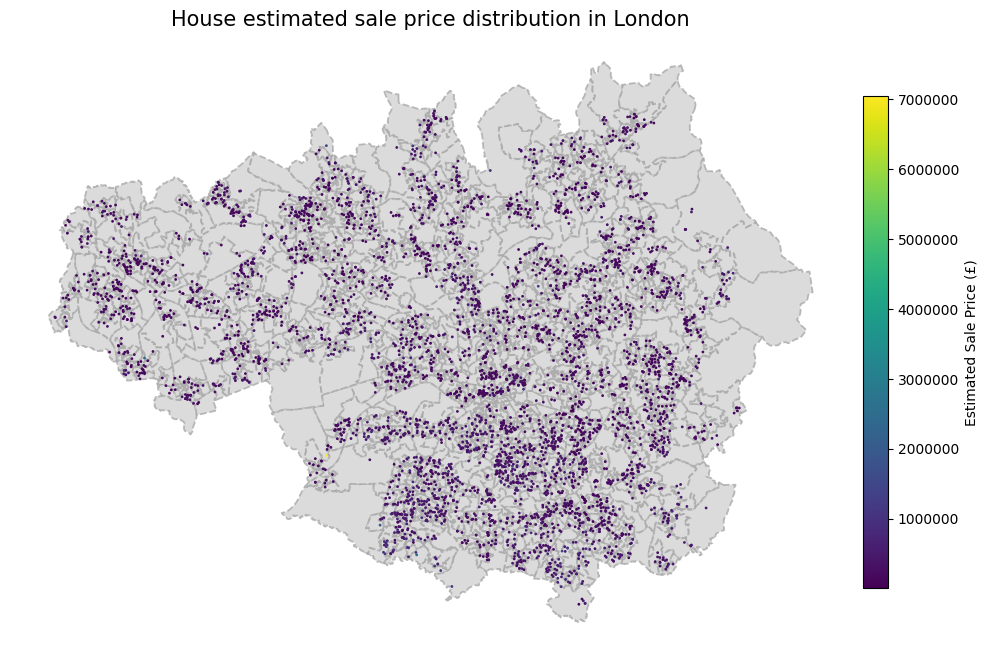

In [47]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# 使用pip安装
#!pip install contextily
import contextily as ctx
# plot one subplot (1 map), with dimensions 16 X 8
f, ax = plt.subplots(1, figsize=(16, 8))
# 转换为GeoDataFrame
filtered_data = gpd.GeoDataFrame(filtered_data, geometry='geometry')

# define the basemap plot it on the sublot axis
base = gm_lsoa.plot(ax=ax,facecolor='lightgrey',alpha=0.8,
                         edgecolor='darkgrey',          # set border color
                         linewidth=1.3,              # set border length
                         linestyle='dashed')          # set border style

# plot the house location on the basemap axis, colour the location points by their saling price
# The following prompt was used in Claude to adjust the look of the legend
filtered_data.plot(ax=base, column='Price',
             cmap='viridis',
             markersize=1,
             legend=True,
             legend_kwds={
                 'label': "Estimated Sale Price (£)",
                 'shrink': 0.8,
                 'aspect': 20,
                 'pad': 0.01,
                 'orientation': 'vertical',
                 'format': "%.0f"
             })
# remove axis
ax.set_axis_off()
# add title
ax.set_title('House estimated sale price distribution in London', fontsize=15)
# add a North arrow
#add_north_arrow(ax=ax, scale=.75, xlim_pos=0.1, ylim_pos=.85, color='#000', text_scaler=2, text_yT=-1.25)

# show the map
plt.show()

In [ ]:
# Data-preprocessing
# data source : https://www.kaggle.com/datasets/jakewright/house-price-data/data
# read the london house price data from github that have been uploaded, using the raw link
lon_hp=pd.read_csv('https://raw.githubusercontent.com/lancelotH/python_portfolio/main/kaggle_london_house_price_data.csv')

In [ ]:
import geopandas as gpd

# 读取整个 GeoPackage 文件
gdf = gpd.read_file('your_data.gpkg')

# 查看数据概况
print(gdf.head())
print(gdf.crs)  # 坐标参考系统
print(gdf.geometry.name)  # 几何列的名称

In [ ]:
# 步骤1: 导入必要的库
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

# 步骤2: 挂载Google Drive
drive.mount('/content/drive')

# 步骤3: 设置Shapefile的路径
# 假设您的文件位于Google Drive的"GIS_Data/Manchester"文件夹中
shp_path = '/content/drive/MyDrive/Python_final/BoundaryData/england_lsoa_2021.shp'

# 步骤4: 读取Shapefile
gdf = gpd.read_file(shp_path)
lsoa_path = '/content/drive/MyDrive/Python_final/BoundaryData/england_lsoa_2021.shp'
lsoa_all = gpd.read_file(lsoa_path)
# 打印数据基本信息
print(f"原始LSOA数量: {len(lsoa_all)}")
print(f"列名: {lsoa_all.columns.tolist()}")

# 定义大曼彻斯特区域的所有地区名称
gm_areas = ['Manchester', 'Salford', 'Bolton', 'Bury', 'Oldham',
           'Rochdale', 'Stockport', 'Tameside', 'Trafford', 'Wigan']

# 使用str.startswith方法筛选LSOA
# 创建筛选条件
filter_condition = lsoa_all['lsoa21nm'].str.startswith(tuple(gm_areas))

# 应用筛选条件
greater_manchester_lsoa = lsoa_all[filter_condition]

# 打印筛选结果信息
print(f"\n筛选后的LSOA数量: {len(greater_manchester_lsoa)}")
print(f"按地区分布:")
for area in gm_areas:
    count = greater_manchester_lsoa['lsoa21nm'].str.startswith(area).sum()
    print(f"- {area}: {count}个LSOA")

In [7]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 确保LSOA数据使用英国国家网格坐标系
if greater_manchester_lsoa.crs != "EPSG:27700":
    greater_manchester_lsoa = greater_manchester_lsoa.to_crs("EPSG:27700")

print(f"LSOA边界加载完成: {len(greater_manchester_lsoa)}个LSOA区域")

# 步骤2: 读取邮政编码点数据，但只保留大曼彻斯特地区的
# -----------------------------------------------------
print("读取邮政编码点数据...")
postcode_points_all = gpd.read_file('/content/drive/MyDrive/Python_final/codepo_gb.gpkg')

# 统一列名为小写(避免大小写不一致问题)
postcode_points_all.columns = [col.lower() for col in postcode_points_all.columns]

# 确保邮政编码点数据使用相同的坐标系
if postcode_points_all.crs != greater_manchester_lsoa.crs:
    postcode_points_all = postcode_points_all.to_crs(greater_manchester_lsoa.crs)

# 使用空间连接筛选位于大曼彻斯特的邮政编码点
print("筛选位于大曼彻斯特的邮政编码点...")
manchester_postcodes = gpd.sjoin(
    postcode_points_all,
    greater_manchester_lsoa,
    how="inner",  # 内连接，只保留位于LSOA内的点
    predicate="within"  # 点必须完全位于多边形内
)

# 去除重复项(如果有)
manchester_postcodes = manchester_postcodes.drop_duplicates(subset=['postcode'])

print(f"大曼彻斯特地区邮政编码点: {len(manchester_postcodes)}个")

# 提取必要列：邮政编码和几何信息
postcode_geometry = manchester_postcodes[['postcode', 'geometry']]

# 步骤3: 读取房价数据并筛选出大曼彻斯特地区的记录
# ------------------------------------------------
print("读取房价数据...")
house_prices_all = pd.read_csv('/content/drive/MyDrive/Python_final/pp-2025.csv')
print(f"原始房价数据: {len(house_prices_all)}行")

# 统一邮政编码格式(去除空格，统一大小写)
house_prices_all['Postcode'] = house_prices_all['Postcode'].str.upper().str.replace(' ', '')
postcode_geometry['postcode'] = postcode_geometry['postcode'].str.upper().str.replace(' ', '')

# 筛选具有大曼彻斯特邮政编码的房价记录
manchester_postcodes_list = postcode_geometry['postcode'].tolist()

# 使用isin进行筛选，速度更快
print("筛选大曼彻斯特地区的房价数据...")
manchester_prices = house_prices_all[house_prices_all['Postcode'].isin(manchester_postcodes_list)]
print(f"筛选后的房价数据: {len(manchester_prices)}行")

# 步骤4: 将空间信息添加到房价数据
# --------------------------------------
print("合并空间信息...")
# 准备用于合并的数据框
geometry_lookup = postcode_geometry.set_index('postcode')

# 创建几何点列表
geometries = []

# 遍历房价数据，对每条记录分配几何信息
for idx, row in manchester_prices.iterrows():
    postcode = row['Postcode']
    try:
        # 获取邮政编码对应的几何信息
        point_geom = geometry_lookup.loc[postcode, 'geometry']
        geometries.append(point_geom)
    except KeyError:
        # 如果找不到对应的邮政编码，添加None
        geometries.append(None)

# 创建GeoDataFrame
manchester_prices_gdf = gpd.GeoDataFrame(
    manchester_prices,
    geometry=geometries,
    crs=manchester_postcodes.crs
)

# 去除没有几何信息的记录
manchester_prices_gdf = manchester_prices_gdf.dropna(subset=['geometry'])
print(f"最终带空间信息的房价数据: {len(manchester_prices_gdf)}行")

# 步骤5: 执行空间连接，确定每个房价记录所在的LSOA
# ------------------------------------------------
print("执行空间连接，确定LSOA归属...")
manchester_prices_with_lsoa = gpd.sjoin(
    manchester_prices_gdf,
    greater_manchester_lsoa[['lsoa21cd', 'lsoa21nm', 'geometry']],
    how="left",
    predicate="within"
)

# 统计每个LSOA的房价记录数
lsoa_counts = manchester_prices_with_lsoa.groupby('lsoa21nm').size()
print(f"有房价数据的LSOA数量: {len(lsoa_counts)}")

# 额外步骤：创建数据摘要统计
# ---------------------------
summary = pd.DataFrame({
    'LSOA': manchester_prices_with_lsoa['lsoa21nm'],
    'Price': manchester_prices_with_lsoa['Price']
})

# 按LSOA分组计算统计量
lsoa_stats = summary.groupby('LSOA').agg({
    'Price': ['count', 'mean', 'median', 'min', 'max', 'std']
})

LSOA边界加载完成: 1702个LSOA区域
读取邮政编码点数据...
筛选位于大曼彻斯特的邮政编码点...
大曼彻斯特地区邮政编码点: 72140个
读取房价数据...
原始房价数据: 106006行
筛选大曼彻斯特地区的房价数据...
筛选后的房价数据: 4566行
合并空间信息...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


最终带空间信息的房价数据: 4566行
执行空间连接，确定LSOA归属...
有房价数据的LSOA数量: 1477


This is an example block of mardown text I want to reference <a href="#ref1">[1]</a>. I might need to add some more citations <a href="#ref2">[2]</a><a href="#ref2">[3]</a>



Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

## References
<p><a href="add_url_here">[1]</a>Footnote citation goes here</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5990">[2]</a>GEOG5990M course materials</p>
<p><a href="add_url_here">[3]</a>Citation 3</p>